In [1]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda

c:\Users\Tarun\miniconda3\envs\denoising-conda-env\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


KeyboardInterrupt: 

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda

c:\Users\Tarun\miniconda3\envs\denoising-conda-env\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


KeyboardInterrupt: 

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda

c:\Users\Tarun\miniconda3\envs\denoising-conda-env\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


KeyboardInterrupt: 

In [ ]:
import os
import cv2
import numpy as np
from glob import glob
from scipy.io import loadmat
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [ ]:
import numpy as np
import time
import os
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Convolution2D,BatchNormalization,ReLU,LeakyReLU,Add,Activation
from tensorflow.keras.layers import GlobalAveragePooling2D,AveragePooling2D,UpSampling2D

In [ ]:
from keras.utils import normalize
import os
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
NUM_CLASSES = 4
INPUT_HEIGHT = 224
INPUT_WIDTH = 224
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-4
EPOCHS = 20
BATCH_SIZE = 32
MIXED_PRECISION = False # Important to prevent Nan's.
SHUFFLE = True

# Mixed-precision setting
if MIXED_PRECISION:
    policy = keras.mixed_precision.Policy("mixed_float16")
    keras.mixed_precision.set_global_policy(policy)

In [7]:

import skimage.io as io
from skimage import transform
stack_path = '/content/gdrive/MyDrive/sandstone_data_for_ML/full_labels_for_deep_learning/128_patches/images_as_128x128_patches.tif'
train_images = io.imread(stack_path)

resized_train_images = []
for image in train_images[:300]:
    image = tf.keras.applications.vgg16.preprocess_input(image)
    resized_train_images.append(image)

train_images = np.array(resized_train_images)

print("Shape of the TIFF stack:", train_images.shape)

Shape of the TIFF stack: (300, 128, 128)


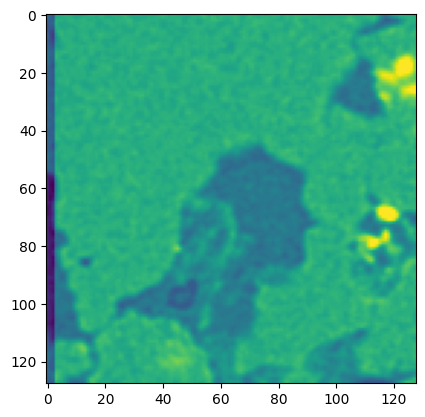

In [8]:
plt.imshow(train_images[0])

In [9]:
stack_path = '/content/gdrive/MyDrive/sandstone_data_for_ML/full_labels_for_deep_learning/128_patches/masks_as_128x128_patches.tif'
train_masks = io.imread(stack_path)

resized_train_masks = []
for image in train_masks[:300]:
    resized_train_masks.append(image)
train_masks = np.array(resized_train_masks)

print("Shape of the TIFF stack:", train_masks.shape)

Shape of the TIFF stack: (300, 128, 128)


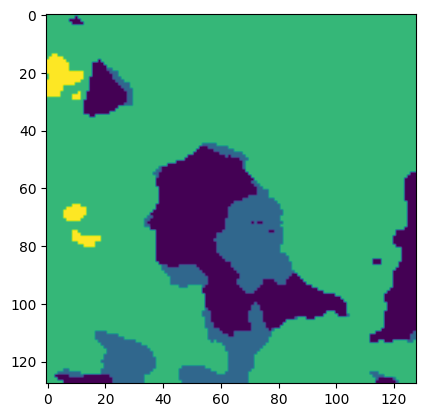

In [10]:
plt.imshow(train_masks[0])

In [11]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = train_masks.shape
print(n, h, w)
train_masks_reshaped = train_masks.reshape(-1,1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)
np.unique(train_masks_encoded_original_shape)

300 128 128


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0, 1, 2, 3])

In [12]:
print(train_images.shape)

train_images.shape

(300, 128, 128)


(300, 128, 128)

In [13]:
train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)
print(train_masks_input.shape)

(300, 128, 128, 1)


In [14]:
np.unique(train_masks_input[0])

array([0, 1, 2, 3])

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_images, train_masks_input, test_size = 0.10, random_state = 0)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(270, 128, 128)
(30, 128, 128)
(270, 128, 128, 1)
(30, 128, 128, 1)


In [16]:
print("Class values in the dataset are ... ", np.unique(y_train))

Class values in the dataset are ...  [0 1 2 3]


In [17]:
# Categorical encoding
from keras.utils import to_categorical
n_classes=4
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))
test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

In [18]:
print(y_train.shape)

(270, 128, 128, 1)


In [19]:
# Class weights to handle class imbalance
class_labels = np.unique(train_masks_reshaped_encoded)
class_counts = [np.sum(train_masks_reshaped_encoded == label) for label in class_labels]
total_samples = len(train_masks_reshaped_encoded)
class_weights = total_samples / (len(class_labels) * np.array(class_counts))

# Print the calculated class weights
print("Class Weights:", class_weights)

Class Weights: [1.92494772 2.88047033 0.33074303 9.10377324]


# Defining the model (ReSeg:)



In [20]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import numpy as np

In [21]:
import tensorflow as tf

class ReNet(tf.keras.Model):
    def __init__(self, n_input, n_units, patch_size=(1, 1)):
        super(ReNet, self).__init__()

        self.patch_size_height = int(patch_size[0])
        self.patch_size_width = int(patch_size[1])

        assert self.patch_size_height >= 1
        assert self.patch_size_width >= 1

        self.rnn_hor = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(n_units, return_sequences=True))
        self.rnn_ver = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(n_units, return_sequences=True))

    def rnn_forward(self, x, hor_or_ver):
        assert hor_or_ver in ['hor', 'ver']

        shape = tf.shape(x)
        b, n_height, n_width, n_filters = shape[0], shape[1], shape[2], shape[3]

        x = tf.reshape(x, (b * n_height, n_width, n_filters))
        if hor_or_ver == 'hor':
            x = self.rnn_hor(x)
        else:
            x = self.rnn_ver(x)
        x = tf.reshape(x, (b, n_height, n_width, -1))

        return x

    def call(self, x):
        x = tf.transpose(x, (0, 2, 3, 1))
        x = self.rnn_forward(x, 'hor')
        x = tf.transpose(x, (0, 2, 1, 3))
        x = self.rnn_forward(x, 'ver')
        x = tf.transpose(x, (0, 2, 1, 3))
        x = tf.transpose(x, (0, 3, 1, 2))

        return x

class CNN(tf.keras.Model):
    def __init__(self):
        super(CNN, self).__init__()

        vgg16 = tf.keras.applications.VGG16(weights=None, include_top=False, input_tensor=keras.Input(shape=(128, 128, 1)))
        for layer in vgg16.layers:
          layer.trainable = True

        self.model = tf.keras.Sequential(vgg16.layers[:-5])

    def call(self, x):
        x = self.model(x)

        return x

class ReSeg(tf.keras.Model):
    def __init__(self, n_classes):
        super(ReSeg, self).__init__()

        self.n_classes = n_classes

        self.cnn = CNN()
        self.renet1 = ReNet(256, 10)
        self.renet2 = ReNet(100 * 2, 25)
        self.upsampling1 = tf.keras.layers.Conv2DTranspose(50, kernel_size=(2, 2), strides=(2, 2))
        self.relu1 = tf.keras.layers.Activation('tanh')
        self.upsampling2 = tf.keras.layers.Conv2DTranspose(50, kernel_size=(2, 2), strides=(2, 2))
        self.relu2 = tf.keras.layers.Activation('relu')
        self.output_layer = tf.keras.layers.Conv2D(self.n_classes, kernel_size=(1, 1), strides=(1, 1))

    def call(self, x):
        x = self.cnn(x)
        x = self.renet1(x)
        x = self.renet2(x)
        x = self.relu1(self.upsampling1(x))
        x = self.relu2(self.upsampling2(x))
        x = self.output_layer(x)
        x = tf.image.resize(x, size=(128, 128), method=tf.image.ResizeMethod.BILINEAR)

        return x

model = ReSeg(n_classes=4)
model.build(input_shape=(1, 128, 128, 1))
model.summary()

Model: "re_seg"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cnn (CNN)                   multiple                  7634112   
                                                                 
 re_net (ReNet)              multiple                  3600      
                                                                 
 re_net_1 (ReNet)            multiple                  18600     
                                                                 
 conv2d_transpose (Conv2DTr  multiple                  102450    
 anspose)                                                        
                                                                 
 activation (Activation)     multiple                  0         
                                                                 
 conv2d_transpose_1 (Conv2D  multiple                  10050     
 Transpose)                                                 

In [22]:
X_train.shape

(270, 128, 128)

In [23]:
model.call(np.array([X_train[0]]))

<tf.Tensor: shape=(1, 128, 128, 4), dtype=float32, numpy=
array([[[[ 1.1696521e-03,  1.3977775e-03,  2.7179222e-03,
           1.4255168e-03],
         [ 1.4359769e-03,  1.0137109e-03,  2.9095355e-03,
           1.1138305e-03],
         [ 1.9686266e-03,  2.4557786e-04,  3.2927622e-03,
           4.9045769e-04],
         ...,
         [ 2.3631053e-02,  3.0967502e-02, -6.7895786e-03,
          -9.7493632e-03],
         [ 7.9261633e-03, -4.0246232e-04,  1.2397404e-02,
          -7.7805603e-03],
         [ 7.3717383e-05, -1.6087443e-02,  2.1990897e-02,
          -6.7961589e-03]],

        [[-1.4349752e-03,  3.2606666e-05,  3.6468282e-03,
          -1.1256934e-03],
         [-8.1607187e-04,  2.1550205e-04,  2.8120161e-03,
          -1.0298740e-03],
         [ 4.2173476e-04,  5.8129267e-04,  1.1423916e-03,
          -8.3823479e-04],
         ...,
         [-2.0596759e-02,  4.8420844e-03,  3.5730191e-02,
           5.1714638e-03],
         [-1.0638462e-02,  8.8655604e-03,  4.7702998e-02,
    

In [24]:
print(X_train[0].shape)
loss = keras.losses.CategoricalCrossentropy(from_logits=True)

optimizer=keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
model.summary

(128, 128)


<bound method Model.summary of <__main__.ReSeg object at 0x7b4eec480340>>

In [25]:
X_train.shape, y_train.shape, y_train_cat.shape, y_test_cat.shape, X_test.shape

((270, 128, 128),
 (270, 128, 128, 1),
 (270, 128, 128, 4),
 (30, 128, 128, 4),
 (30, 128, 128))

In [26]:
history = model.fit(X_train, y_train_cat,
                    epochs=20,
                    validation_data=(X_test, y_test_cat),
                    shuffle=False, batch_size=4)

Epoch 1/20
68/68 [==============================] - 31s 163ms/step - loss: 0.8520 - accuracy: 0.7520 - val_loss: 0.8289 - val_accuracy: 0.7404
Epoch 2/20
68/68 [==============================] - 6s 83ms/step - loss: 0.7872 - accuracy: 0.7576 - val_loss: 0.8286 - val_accuracy: 0.7404
Epoch 3/20
68/68 [==============================] - 7s 102ms/step - loss: 0.7869 - accuracy: 0.7576 - val_loss: 0.8287 - val_accuracy: 0.7404
Epoch 4/20
68/68 [==============================] - 6s 85ms/step - loss: 0.7869 - accuracy: 0.7576 - val_loss: 0.8287 - val_accuracy: 0.7404
Epoch 5/20
68/68 [==============================] - 6s 94ms/step - loss: 0.7868 - accuracy: 0.7576 - val_loss: 0.8285 - val_accuracy: 0.7404
Epoch 6/20
68/68 [==============================] - 7s 99ms/step - loss: 0.7867 - accuracy: 0.7576 - val_loss: 0.8283 - val_accuracy: 0.7404
Epoch 7/20
68/68 [==============================] - 6s 84ms/step - loss: 0.7867 - accuracy: 0.7576 - val_loss: 0.8282 - val_accuracy: 0.7404
Epoch 8/20

In [37]:
print(X_test.shape, y_test_cat.shape)

metrics = model.evaluate(X_test, y_test_cat, batch_size=1)
print(metrics)
print("Accuracy is = ", (metrics[1] * 100.0), "%")

(30, 128, 128) (30, 128, 128, 4)
30/30 [==============================] - 1s 37ms/step - loss: 0.8228 - accuracy: 0.7404
[0.8227947950363159, 0.740435779094696]
Accuracy is =  74.0435779094696 %


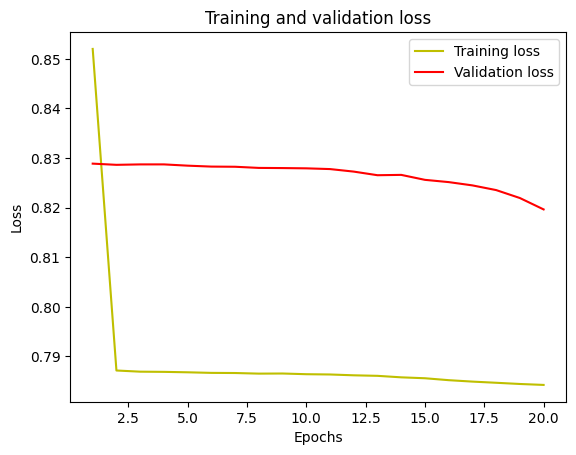

{'loss': [0.8520052433013916, 0.7871590852737427, 0.7869224548339844, 0.7868841290473938, 0.786796510219574, 0.7866784930229187, 0.7866511344909668, 0.7865287661552429, 0.7865521907806396, 0.7864117622375488, 0.7863555550575256, 0.7861900329589844, 0.7860828638076782, 0.7857804894447327, 0.7855963706970215, 0.7852081656455994, 0.7849201560020447, 0.7846834063529968, 0.7844405770301819, 0.7842507362365723], 'accuracy': [0.7519727945327759, 0.7575891613960266, 0.7575891613960266, 0.7575891613960266, 0.7575891613960266, 0.7575891613960266, 0.7575891613960266, 0.7575891613960266, 0.7575891613960266, 0.7575891613960266, 0.7575891613960266, 0.7575891613960266, 0.7575891613960266, 0.7575891613960266, 0.7575891613960266, 0.7575891613960266, 0.7575891613960266, 0.7575891613960266, 0.7575893998146057, 0.7575891613960266], 'val_loss': [0.8288729190826416, 0.828631579875946, 0.8287179470062256, 0.8287208080291748, 0.8284648656845093, 0.8282772302627563, 0.8282443284988403, 0.828010618686676, 0.827

In [38]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(history.history)

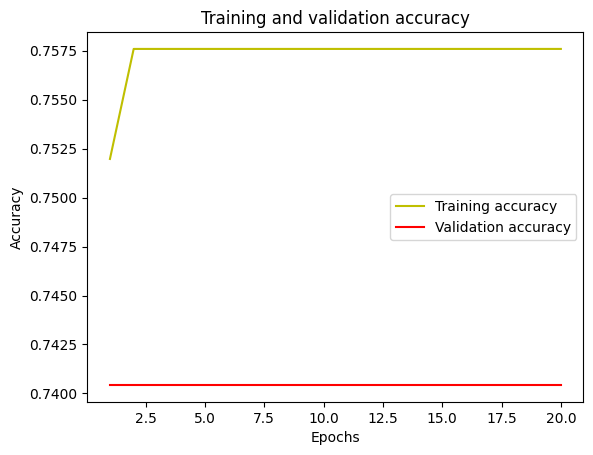

In [39]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'y', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

9/9 [==============================] - 1s 96ms/step


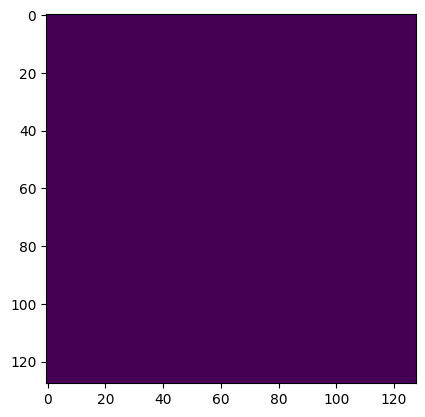

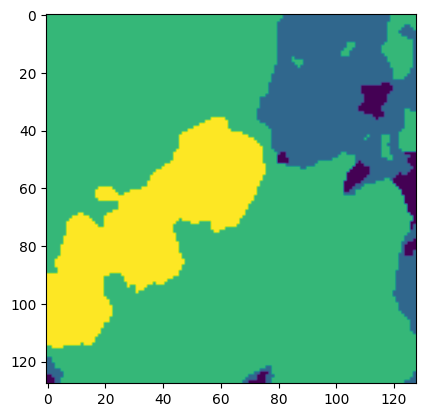

In [44]:
# Visualizing model output
# prediction on training set
#print(repeat_channels(X_test[3]))
y_pred=model.predict(X_train)
y_pred_argmax=np.argmax(y_pred, axis=-1)
plt.imshow(y_pred_argmax[0])
plt.show()
#print(y_pred)
plt.imshow(y_train[0])
plt.show()

In [45]:
from scipy.ndimage import rotate
def apply_random_rotation(image, mask):
    angle = np.random.uniform(0, 180)
    rotated_image = rotate(image, angle, reshape=False, mode='reflect')
    rotated_mask = np.zeros_like(mask)
    for channel in range(mask.shape[-1]):
        rotated_channel = rotate(mask[..., channel], angle, reshape=False, mode='reflect')
        rotated_mask[..., channel] = (rotated_channel > 0.5).astype(np.float32)
    return rotated_image, rotated_mask

In [46]:
def apply_horizontal_flip(image, mask):
    flipped_image = np.fliplr(image)
    flipped_mask = np.zeros_like(mask)
    for channel in range(mask.shape[-1]):
        flipped_channel = np.fliplr(mask[..., channel])
        flipped_mask[..., channel] = flipped_channel
    return flipped_image, flipped_mask

In [47]:
def apply_vertical_flip(image, mask):
    flipped_image = np.flipud(image)
    flipped_mask = np.zeros_like(mask)
    for channel in range(mask.shape[-1]):
        flipped_channel = np.flipud(mask[..., channel])
        flipped_mask[..., channel] = flipped_channel
    return flipped_image, flipped_mask

In [48]:
augmented_image, augmented_mask = apply_vertical_flip(X_train[0], y_train_cat[0])
print("Image Shape: ", augmented_image.shape)
print("Mask Shape: ", augmented_mask.shape)

Image Shape:  (128, 128)
Mask Shape:  (128, 128, 4)


In [49]:
augmented_images = []
augmented_masks = []
for i in range(X_train.shape[0]):
    rot_img, rot_mask = apply_random_rotation(X_train[i], y_train_cat[i])
    h_flip_img, h_flip_mask = apply_horizontal_flip(X_train[i], y_train_cat[i])
    v_flip_img, v_flip_mask = apply_vertical_flip(X_train[i], y_train_cat[i])

    augmented_images.append(rot_img)
    augmented_images.append(h_flip_img)
    augmented_images.append(v_flip_img)

    augmented_masks.append(rot_mask)
    augmented_masks.append(h_flip_mask)
    augmented_masks.append(v_flip_mask)

augmented_images = np.array(augmented_images)
augmented_masks = np.array(augmented_masks)
print("Aug Image Shape: ", augmented_images.shape)
print("Aug Mask Shape: ", augmented_masks.shape)

Aug Image Shape:  (810, 128, 128)
Aug Mask Shape:  (810, 128, 128, 4)


In [50]:
X_train_aug = np.concatenate((X_train, augmented_images), axis=0)
y_train_aug = np.concatenate((y_train_cat, augmented_masks), axis = 0)

#y_train_aug = np.argmax(y_train_aug, axis=-1)
#y_train_aug = y_train_aug[..., np.newaxis]

print("Full Aug Image Shape: ", X_train_aug.shape)
print("Full Aug Mask Shape: ", y_train_aug.shape)

print(y_test.shape, X_test.shape)

Full Aug Image Shape:  (1080, 128, 128)
Full Aug Mask Shape:  (1080, 128, 128, 4)
(30, 128, 128, 1) (30, 128, 128)


In [51]:
# Increasing the number of epochs from 50 ==> 100
# Using the augmented dataset of images and masks
history_aug = model.fit(X_train_aug, y_train_aug,
                    verbose=1,
                        batch_size=1,
                    epochs=20,
                    validation_data=(X_test, y_test_cat),
                    shuffle=False)

Epoch 1/20
1080/1080 [==============================] - 80s 74ms/step - loss: 0.7818 - accuracy: 0.7585 - val_loss: 0.8120 - val_accuracy: 0.7404
Epoch 2/20
1080/1080 [==============================] - 79s 73ms/step - loss: 0.7742 - accuracy: 0.7585 - val_loss: 0.7997 - val_accuracy: 0.7418
Epoch 3/20
1080/1080 [==============================] - 80s 74ms/step - loss: 0.7692 - accuracy: 0.7588 - val_loss: 0.7911 - val_accuracy: 0.7436
Epoch 4/20
1080/1080 [==============================] - 80s 74ms/step - loss: 0.7630 - accuracy: 0.7596 - val_loss: 0.7822 - val_accuracy: 0.7442
Epoch 5/20
1080/1080 [==============================] - 80s 74ms/step - loss: 0.7566 - accuracy: 0.7616 - val_loss: 0.7632 - val_accuracy: 0.7573
Epoch 6/20
1080/1080 [==============================] - 81s 75ms/step - loss: 0.7525 - accuracy: 0.7627 - val_loss: 0.7564 - val_accuracy: 0.7647
Epoch 7/20
1080/1080 [==============================] - 80s 74ms/step - loss: 0.7488 - accuracy: 0.7643 - val_loss: 0.7547 -

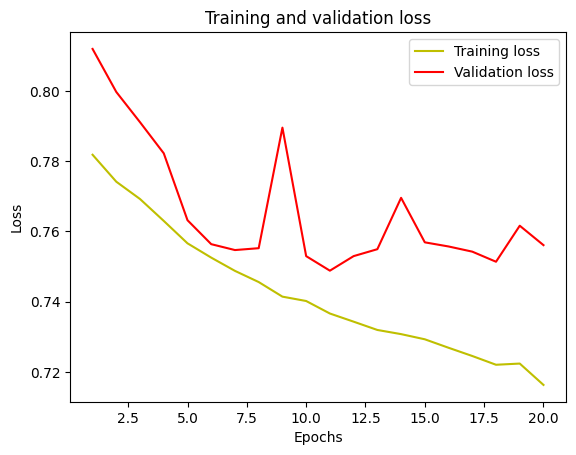

In [52]:
loss = history_aug.history['loss']
val_loss = history_aug.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

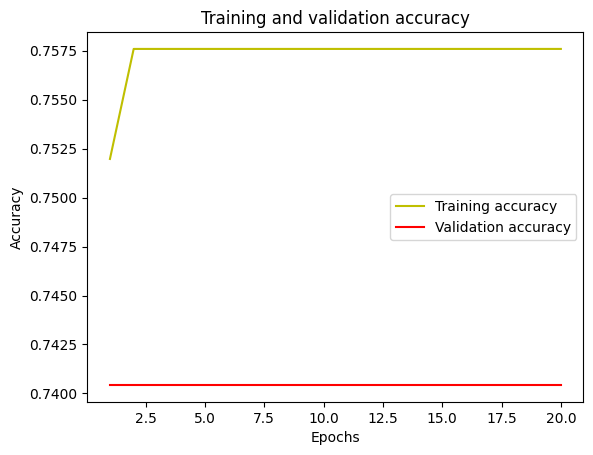

In [53]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'y', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Comparitive analysis of evaluation metrics of the models on the sandstone dataset

1/1 [==============================] - 2s 2s/step


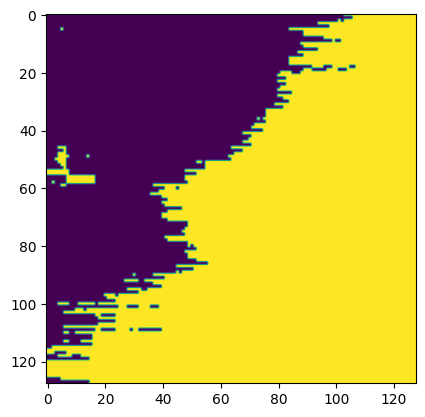

In [54]:
# prediction on teting set
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)

plt.imshow(y_pred_argmax[0])

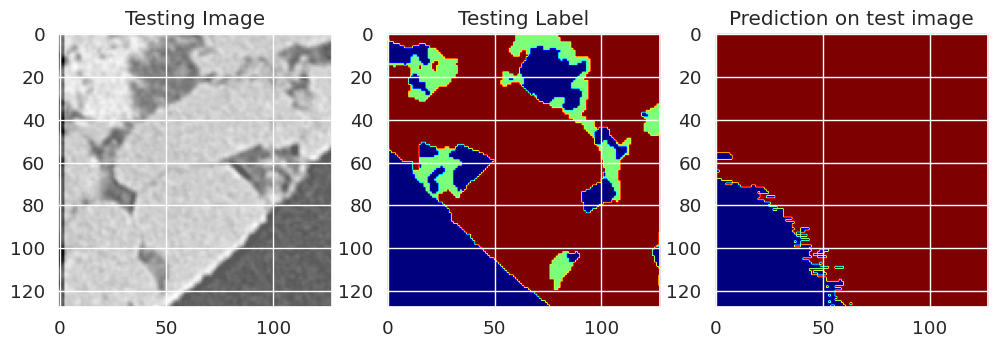

In [67]:
test_img = X_test[5]
ground_truth = y_test[5]

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(y_pred_argmax[5], cmap='jet')
plt.show()

In [56]:
print("true: ", y_test_cat.shape)
print("pred: ", y_pred.shape)

true:  (30, 128, 128, 4)
pred:  (30, 128, 128, 4)


In [57]:
# Converting masks to one channel format with values 0, 1, 2 and 3
y_pred_img = np.argmax(y_pred, axis=3)

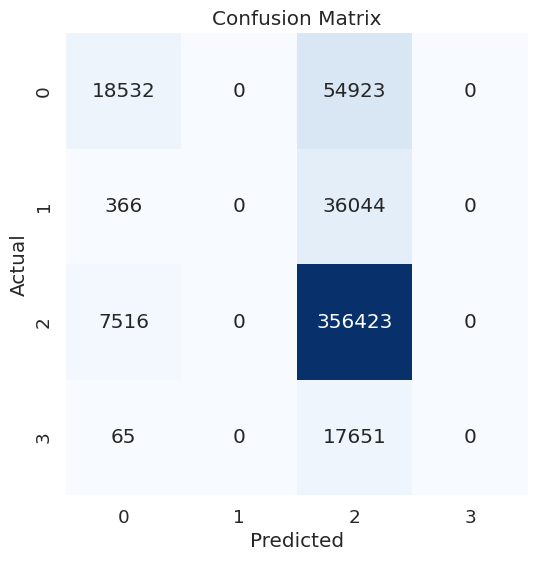

In [58]:
# Confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

# Compute the confusion matrix
confusion_mat = confusion_matrix(y_test.flatten(), y_pred_img.flatten())

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust the font size if needed
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', square=True,
            cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [59]:
# Pix Accuracy
def accuracy(gnd, pred):
    gnd_flat = gnd.flatten()
    pred_flat = pred.flatten()
    matching_pixels = np.sum(gnd_flat == pred_flat)
    total_pixels = gnd_flat.shape[0]
    accuracy = matching_pixels / total_pixels
    return accuracy

print(f"Pixel wise accuracy: {round(accuracy(y_test, y_pred_img)*100, 2)}%")

Pixel wise accuracy: 76.28%


In [60]:
# precision
from sklearn.metrics import precision_score, recall_score, f1_score

def classwise_precision(y_test, y_pred_img, num_classes):
    precision = np.zeros(num_classes)
    for i in range(num_classes):
        precision[i] = precision_score((y_test == i).flatten(), (y_pred_img == i).flatten())
    return precision
prec_classes = classwise_precision(y_test, y_pred_img, 4)
print(f"Class 0 precision: {round(prec_classes[0]*100)}%")
print(f"Class 1 precision: {round(prec_classes[1]*100)}%")
print(f"Class 2 precision: {round(prec_classes[2]*100)}%")
print(f"Class 3 precision: {round(prec_classes[3]*100)}%")

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Class 0 precision: 70%
Class 1 precision: 0%
Class 2 precision: 77%
Class 3 precision: 0%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [61]:
# recall
def classwise_recall(y_test, y_pred_img, num_classes):
    recall = np.zeros(num_classes)
    for i in range(num_classes):
        recall[i] = recall_score((y_test == i).flatten(), (y_pred_img == i).flatten())
    return recall

rec_classes = classwise_recall(y_test, y_pred_img, 4)
print(f"Class 0 precision: {round(rec_classes[0]*100)}%")
print(f"Class 1 precision: {round(rec_classes[1]*100)}%")
print(f"Class 2 precision: {round(rec_classes[2]*100)}%")
print(f"Class 3 precision: {round(rec_classes[3]*100)}%")

Class 0 precision: 25%
Class 1 precision: 0%
Class 2 precision: 98%
Class 3 precision: 0%


In [62]:
# f1-score
def classwise_f1_score(y_test, y_pred_img, num_classes):
    f1_scores = np.zeros(num_classes)
    for i in range(num_classes):
        f1_scores[i] = f1_score((y_test == i).flatten(), (y_pred_img == i).flatten())
    return f1_scores

f1_classes = classwise_recall(y_test, y_pred_img, 4)I
print(f"Class 0 precision: {round(f1_classes[0]*100)}%")
print(f"Class 1 precision: {round(f1_classes[1]*100)}%")
print(f"Class 2 precision: {round(f1_classes[2]*100)}%")
print(f"Class 3 precision: {round(f1_classes[3]*100)}%")

Class 0 precision: 25%
Class 1 precision: 0%
Class 2 precision: 98%
Class 3 precision: 0%


In [63]:
# mean iou
from keras.metrics import MeanIoU
n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.2454759


In [64]:
# Classwise iou
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3] + values[1,0]+ values[2,0]+ values[3,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3] + values[0,1]+ values[2,1]+ values[3,1])
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3] + values[0,2]+ values[1,2]+ values[3,2])
class4_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[0,3]+ values[1,3]+ values[2,3])

print("IoU for class1 is: ", class1_IoU)
print("IoU for class2 is: ", class2_IoU)
print("IoU for class3 is: ", class3_IoU)
print("IoU for class4 is: ", class4_IoU)

[[1.85320e+04 0.00000e+00 5.49230e+04 0.00000e+00]
 [3.66000e+02 0.00000e+00 3.60440e+04 0.00000e+00]
 [7.51600e+03 0.00000e+00 3.56423e+05 0.00000e+00]
 [6.50000e+01 0.00000e+00 1.76510e+04 0.00000e+00]]
IoU for class1 is:  0.22766025
IoU for class2 is:  0.0
IoU for class3 is:  0.7542434
IoU for class4 is:  0.0


Training Set

In [68]:
# prediction on training set
y_pred=model.predict(X_train)
y_pred_argmax=np.argmax(y_pred, axis=3)

9/9 [==============================] - 1s 132ms/step


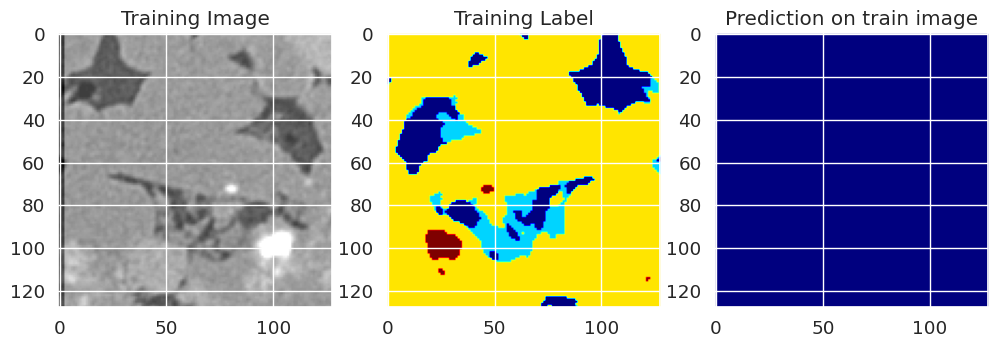

In [75]:
import random
train_img_number = random.randint(0, len(X_train))



plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Training Image')
plt.imshow(X_train[train_img_number], cmap='gray')
plt.subplot(232)
plt.title('Training Label')
plt.imshow(y_train[train_img_number], cmap='jet')
plt.subplot(233)
plt.title('Prediction on train image')
plt.imshow(y_pred_argmax[train_img_number], cmap='jet')
plt.show()

In [76]:
print("true: ", y_train_cat.shape)
print("pred: ", y_pred.shape)

true:  (270, 128, 128, 4)
pred:  (270, 128, 128, 4)


In [77]:
# Converting masks to one channel format with values 0, 1, 2 and 3
y_pred_img = np.argmax(y_pred, axis=3)

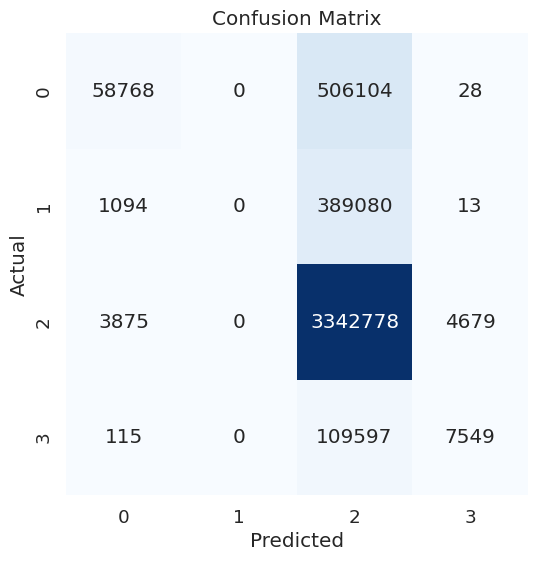

In [79]:
# Confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

# Compute the confusion matrix
confusion_mat = confusion_matrix(y_train.flatten(), y_pred_img.flatten())

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust the font size if needed
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', square=True,
            cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [80]:
# Pix Accuracy
def accuracy(gnd, pred):
    gnd_flat = gnd.flatten()
    pred_flat = pred.flatten()
    matching_pixels = np.sum(gnd_flat == pred_flat)
    total_pixels = gnd_flat.shape[0]
    accuracy = matching_pixels / total_pixels
    return accuracy

print(f"Pixel wise accuracy: {round(accuracy(y_train, y_pred_img)*100, 2)}%")

Pixel wise accuracy: 77.06%


In [82]:
# precision
from sklearn.metrics import precision_score, recall_score, f1_score

def classwise_precision(y_train, y_pred_img, num_classes):
    precision = np.zeros(num_classes)
    for i in range(num_classes):
        precision[i] = precision_score((y_train == i).flatten(), (y_pred_img == i).flatten())
    return precision
prec_classes = classwise_precision(y_train, y_pred_img, 4)
print(f"Class 0 precision: {round(prec_classes[0]*100)}%")
print(f"Class 1 precision: {round(prec_classes[1]*100)}%")
print(f"Class 2 precision: {round(prec_classes[2]*100)}%")
print(f"Class 3 precision: {round(prec_classes[3]*100)}%")

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Class 0 precision: 92%
Class 1 precision: 0%
Class 2 precision: 77%
Class 3 precision: 62%


In [83]:
# recall
def classwise_recall(y_train, y_pred_img, num_classes):
    recall = np.zeros(num_classes)
    for i in range(num_classes):
        recall[i] = recall_score((y_train == i).flatten(), (y_pred_img == i).flatten())
    return recall

rec_classes = classwise_recall(y_train, y_pred_img, 4)
print(f"Class 0 precision: {round(rec_classes[0]*100)}%")
print(f"Class 1 precision: {round(rec_classes[1]*100)}%")
print(f"Class 2 precision: {round(rec_classes[2]*100)}%")
print(f"Class 3 precision: {round(rec_classes[3]*100)}%")

Class 0 precision: 10%
Class 1 precision: 0%
Class 2 precision: 100%
Class 3 precision: 6%


In [84]:
# f1-score
def classwise_f1_score(y_train, y_pred_img, num_classes):
    f1_scores = np.zeros(num_classes)
    for i in range(num_classes):
        f1_scores[i] = f1_score((y_train == i).flatten(), (y_pred_img == i).flatten())
    return f1_scores

f1_classes = classwise_recall(y_train, y_pred_img, 4)
print(f"Class 0 precision: {round(f1_classes[0]*100)}%")
print(f"Class 1 precision: {round(f1_classes[1]*100)}%")
print(f"Class 2 precision: {round(f1_classes[2]*100)}%")
print(f"Class 3 precision: {round(f1_classes[3]*100)}%")

Class 0 precision: 10%
Class 1 precision: 0%
Class 2 precision: 100%
Class 3 precision: 6%


In [85]:
# mean iou
from keras.metrics import MeanIoU
n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(y_train[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.2330919


In [86]:
# Classwise iou
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3] + values[1,0]+ values[2,0]+ values[3,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3] + values[0,1]+ values[2,1]+ values[3,1])
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3] + values[0,2]+ values[1,2]+ values[3,2])
class4_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[0,3]+ values[1,3]+ values[2,3])

print("IoU for class1 is: ", class1_IoU)
print("IoU for class2 is: ", class2_IoU)
print("IoU for class3 is: ", class3_IoU)
print("IoU for class4 is: ", class4_IoU)

[[5.876800e+04 0.000000e+00 5.061040e+05 2.800000e+01]
 [1.094000e+03 0.000000e+00 3.890800e+05 1.300000e+01]
 [3.875000e+03 0.000000e+00 3.342778e+06 4.679000e+03]
 [1.150000e+02 0.000000e+00 1.095970e+05 7.549000e+03]]
IoU for class1 is:  0.10310465
IoU for class2 is:  0.0
IoU for class3 is:  0.7673763
IoU for class4 is:  0.061886687
